# EXPLORATION_07

## 1. 데이터 준비와 확인

In [28]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2. 데이터로더 구성

In [29]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','저','나','아니','근데']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [30]:
word_to_index

{'<PAD>': 0,
 '<BOS>': 1,
 '<UNK>': 2,
 '<UNUSED>': 3,
 '.': 4,
 '영화': 5,
 '다': 6,
 '고': 7,
 '하': 8,
 '을': 9,
 '보': 10,
 '..': 11,
 '게': 12,
 ',': 13,
 '!': 14,
 '지': 15,
 '있': 16,
 '없': 17,
 '?': 18,
 '좋': 19,
 '었': 20,
 '만': 21,
 '는데': 22,
 '너무': 23,
 '봤': 24,
 '적': 25,
 '안': 26,
 '정말': 27,
 '로': 28,
 '음': 29,
 '것': 30,
 '아': 31,
 '네요': 32,
 '재밌': 33,
 '어': 34,
 '같': 35,
 '점': 36,
 '지만': 37,
 '진짜': 38,
 '했': 39,
 '에서': 40,
 '기': 41,
 '네': 42,
 '않': 43,
 '거': 44,
 '았': 45,
 '수': 46,
 '되': 47,
 '면': 48,
 'ㅋㅋ': 49,
 '말': 50,
 '연기': 51,
 '인': 52,
 '주': 53,
 '내': 54,
 '최고': 55,
 '~': 56,
 '평점': 57,
 '이런': 58,
 '던': 59,
 '어요': 60,
 '할': 61,
 '왜': 62,
 '겠': 63,
 '1': 64,
 '스토리': 65,
 '해': 66,
 '습니다': 67,
 'ㅋㅋㅋ': 68,
 '...': 69,
 '드라마': 70,
 '생각': 71,
 '더': 72,
 '그': 73,
 '싶': 74,
 '사람': 75,
 '듯': 76,
 '때': 77,
 '감동': 78,
 '함': 79,
 '배우': 80,
 '본': 81,
 '까지': 82,
 '뭐': 83,
 '알': 84,
 '만들': 85,
 '내용': 86,
 '볼': 87,
 '감독': 88,
 '보다': 89,
 '라': 90,
 '그냥': 91,
 '재미': 92,
 '시간': 93,
 '지루': 94,
 '

In [31]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [32]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3.  모델구성을 위한 데이터 분석 및 가공

In [33]:
#  encode된 텍스트가 정상적으로 decode되는지 확인해 보겠습니다.
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2.5*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2.5* np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.82820122965716
문장길이 최대 :  116
문장길이 표준편차 :  12.720490177624757
pad_sequences maxlen :  47
전체 문장의 0.9534501558828499%가 maxlen 설정값 이내에 포함됩니다. 


In [34]:
#  padding 방식을 문장 뒤쪽('post')과 앞쪽('pre') 중 어느쪽으로 하느냐에 따라 RNN을 이용한 딥러닝 적용 시 성능 차이가 발생한다는 점입니다.
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(146182, 47)
(146182,)
(49157, 47)
(49157,)


## 4. 모델구성 및 validation set 구성

## 모델 1 -  LSTM

In [35]:
# RNN 모델을 직접 설계해 보겠습니다
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
# [[YOUR CODE]]
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 6688      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


In [36]:
# model 훈련 전에, 훈련용 데이터셋 146182건 중 25000건을 분리하여 검증셋(validation set)으로 사용하도록 합니다. 적절한 validation 데이터는 몇 개가 좋을지 고민해 봅시다.
# validation set 50000건 분리
x_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지 
partial_x_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(96182, 47)
(96182,)


## 5. 모델 훈련 개시

In [37]:
# model 학습을 시작해 봅시다.

model.compile(optimizer='RMSProp',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/10
188/188 [==============================] - 8s 32ms/step - loss: 0.5587 - accuracy: 0.7369 - val_loss: 0.3691 - val_accuracy: 0.8410
Epoch 2/10
188/188 [==============================] - 5s 27ms/step - loss: 0.3384 - accuracy: 0.8589 - val_loss: 0.3429 - val_accuracy: 0.8515
Epoch 3/10
188/188 [==============================] - 5s 26ms/step - loss: 0.3085 - accuracy: 0.8718 - val_loss: 0.3338 - val_accuracy: 0.8552
Epoch 4/10
188/188 [==============================] - 5s 26ms/step - loss: 0.2838 - accuracy: 0.8824 - val_loss: 0.3325 - val_accuracy: 0.8560
Epoch 5/10
188/188 [==============================] - 5s 26ms/step - loss: 0.2686 - accuracy: 0.8883 - val_loss: 0.3310 - val_accuracy: 0.8570
Epoch 6/10
188/188 [==============================] - 5s 26ms/step - loss: 0.2469 - accuracy: 0.8977 - val_loss: 0.3350 - val_accuracy: 0.8571
Epoch 7/10
188/188 [==============================] - 5s 26ms/step - loss: 0.2384 - accuracy: 0.9009 - val_loss: 0.3610 - val_accuracy: 0.8486

In [38]:
# 학습이 끝난 모델을 테스트셋으로 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.3761 - accuracy: 0.8489
[0.3761204481124878, 0.848892331123352]


## 6. Loss, Accuracy 그래프 시각화

In [39]:
# model.fit() 과정 중의 train/validation loss, accuracy 등이 매 epoch마다 history 변수에 저장되어 있습니다.
# 이 데이터를 그래프로 그려 보면, 수행했던 딥러닝 학습이 잘 진행되었는지, 오버피팅 혹은 언더피팅하지 않았는지, 성능을 개선할 수 있는 다양한 아이디어를 얻을 수 있는 좋은 자료가 됩니다.
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


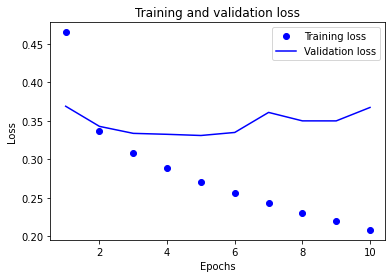

In [40]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

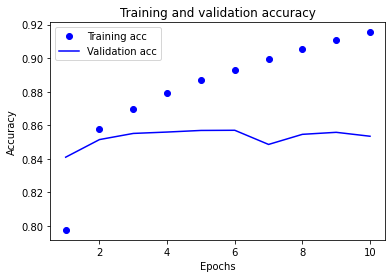

In [41]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 7. 학습된 Embedding 레이어 분석

In [42]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 200)


In [43]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [44]:
# gensim에서 제공하는 패키지를 이용해, 위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용할 수 있습니다.
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['컴퓨터']
vector

array([ 0.02566335, -0.00283116,  0.04248241, -0.08293968,  0.02841168,
        0.0183866 ,  0.01529868,  0.16173023,  0.01109063,  0.05393828,
        0.18869786, -0.11364588, -0.04066772, -0.01295681,  0.00158736,
        0.03969225, -0.00903143,  0.10658022,  0.07847019, -0.04269309,
       -0.03583012, -0.10491871, -0.05710668,  0.03449471,  0.0270969 ,
       -0.172509  ,  0.16651338,  0.00829478, -0.00360294, -0.09094526,
        0.0102892 ,  0.03880386, -0.04510972, -0.01029438, -0.05596092,
        0.08124886, -0.04072746, -0.14814554,  0.00792461,  0.04902835,
       -0.05161835, -0.07185386,  0.00334851,  0.00863923,  0.20033756,
       -0.0195702 ,  0.16599248, -0.07691845, -0.04875683, -0.00273206,
       -0.13373534, -0.0457654 , -0.0177757 , -0.05982031, -0.00390854,
       -0.01737899, -0.00590368, -0.0088568 ,  0.01039471, -0.10338785,
       -0.01015738,  0.01595335,  0.02063164,  0.0284253 , -0.02390737,
       -0.02345708,  0.09763181,  0.00170834,  0.03032244, -0.05

In [45]:
# 워드 벡터를 가지고 재미있는 실험을 해볼 수 있습니다
# 단어를 하나 주고 그와 가장 유사한 단어와 그 유사도를 확인하는 방법이 있습니다. gensim을 사용하면 아래와 같이 해볼 수 있습니다.
word_vectors.similar_by_word("짜증")

[('쓰레기', 0.9107351899147034),
 ('심형래', 0.910100519657135),
 ('졸작', 0.9094471335411072),
 ('아까워', 0.9094246625900269),
 ('식상', 0.9089999794960022),
 ('쓰래', 0.9081932306289673),
 ('어설픈', 0.905677318572998),
 ('그다지', 0.9050755500793457),
 ('한계', 0.9039866924285889),
 ('엉성', 0.9034188985824585)]

## 8. 한국어 Word2Vec 임베딩 활용하여 성능개선

In [46]:
import gensim
from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['컴퓨터']
vector

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


array([-1.517628  , -0.8935504 , -1.4352998 ,  1.5069847 , -1.5178334 ,
        1.1542678 , -2.94064   ,  1.1850045 ,  0.19959009, -1.5288961 ,
       -1.7067502 , -2.1892095 , -0.20728938, -2.2606812 , -2.2283888 ,
        0.32318738, -0.2845471 , -0.07731772, -0.86269003, -1.1722927 ,
       -0.91062415,  0.8440715 ,  0.903278  , -0.84685427,  0.7023384 ,
       -2.1920419 , -0.47571626, -0.60159504, -0.68860835,  0.18944737,
        0.5319404 ,  0.73058116, -0.9658133 , -1.0123725 , -0.36183038,
        2.5851305 ,  0.66589296, -1.7231252 ,  1.7576753 ,  0.88845277,
        1.5791365 , -4.430691  ,  0.36731872,  0.69481534, -0.46041563,
        1.742655  , -1.5077016 ,  0.72209424, -0.04532204, -0.6557301 ,
       -0.71276623,  0.26522732, -0.17656395, -2.4720876 , -0.845565  ,
        0.23591152,  1.3414925 ,  0.77577615, -2.289371  , -0.8078124 ,
        1.4359473 ,  0.22882733, -1.08867   ,  1.2607764 , -1.7469797 ,
        0.06542054,  0.39896825, -0.3160832 , -1.7257563 ,  0.54

In [47]:
word2vec.similar_by_word("짜증")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


[('싫증', 0.7431163787841797),
 ('흠집', 0.590933620929718),
 ('흉내', 0.5880372524261475),
 ('아물', 0.5121865272521973),
 ('울음소리', 0.5063953995704651),
 ('탄로', 0.4944570064544678),
 ('그러', 0.4920297861099243),
 ('내보', 0.48765820264816284),
 ('악취', 0.48633816838264465),
 ('이거', 0.48398834466934204)]

In [48]:
# 우리는 이전 스텝에서 학습했던 모델의 임베딩 레이어를 Word2Vec의 것으로 교체하여 다시 학습시켜 볼 것입니다.

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [49]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 47, 200)           2000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 6688      
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


In [50]:
# 학습의 진행
model.compile(optimizer='RMSProp',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
188/188 [==============================] - 8s 33ms/step - loss: 0.6096 - accuracy: 0.6568 - val_loss: 0.4374 - val_accuracy: 0.8028
Epoch 2/10
188/188 [==============================] - 5s 27ms/step - loss: 0.4188 - accuracy: 0.8125 - val_loss: 0.3805 - val_accuracy: 0.8338
Epoch 3/10
188/188 [==============================] - 5s 26ms/step - loss: 0.3582 - accuracy: 0.8457 - val_loss: 0.3732 - val_accuracy: 0.8358
Epoch 4/10
188/188 [==============================] - 5s 27ms/step - loss: 0.3367 - accuracy: 0.8547 - val_loss: 0.3538 - val_accuracy: 0.8472
Epoch 5/10
188/188 [==============================] - 5s 27ms/step - loss: 0.3166 - accuracy: 0.8660 - val_loss: 0.3470 - val_accuracy: 0.8495
Epoch 6/10
188/188 [==============================] - 5s 27ms/step - loss: 0.3008 - accuracy: 0.8746 - val_loss: 0.3454 - val_accuracy: 0.8516
Epoch 7/10
188/188 [==============================] - 5s 27ms/step - loss: 0.2917 - accuracy: 0.8778 - val_loss: 0.3413 - val_accuracy: 0.8542

In [51]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.3547 - accuracy: 0.8507
[0.3547102212905884, 0.8507435321807861]


In [52]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


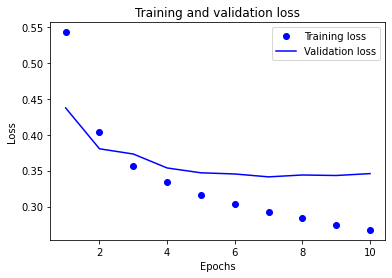

In [53]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

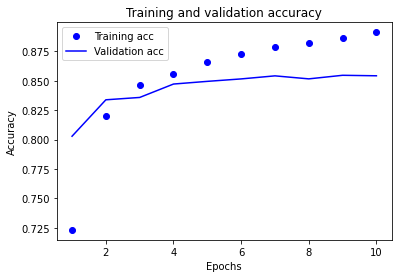

In [54]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

* 한국어 Word2Vec 임베딩 활용하기 전과 후의 그래프를 비교해보면 활용 후 validation 그래프의 모양이 더 좋아진 것을 볼 수 있다.

## 다른 모델들

##  모델 2 - 1D-CNN

### 자체학습 임베딩

In [79]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

cnn_model = keras.Sequential()
cnn_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
cnn_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn_model.add(keras.layers.MaxPooling1D(5))
cnn_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn_model.add(keras.layers.GlobalMaxPooling1D())
cnn_model.add(keras.layers.Dense(8, activation='relu'))
cnn_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

cnn_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 16)          22416     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 16)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                

In [80]:
# model 학습을 시작해 봅시다.

cnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = cnn_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/10
188/188 [==============================] - 8s 35ms/step - loss: 0.6075 - accuracy: 0.6499 - val_loss: 0.3665 - val_accuracy: 0.8361
Epoch 2/10
188/188 [==============================] - 6s 30ms/step - loss: 0.3288 - accuracy: 0.8596 - val_loss: 0.3502 - val_accuracy: 0.8442
Epoch 3/10
188/188 [==============================] - 6s 30ms/step - loss: 0.2746 - accuracy: 0.8896 - val_loss: 0.3561 - val_accuracy: 0.8455
Epoch 4/10
188/188 [==============================] - 6s 30ms/step - loss: 0.2173 - accuracy: 0.9163 - val_loss: 0.3808 - val_accuracy: 0.8424
Epoch 5/10
188/188 [==============================] - 6s 30ms/step - loss: 0.1591 - accuracy: 0.9436 - val_loss: 0.4243 - val_accuracy: 0.8377
Epoch 6/10
188/188 [==============================] - 6s 30ms/step - loss: 0.1141 - accuracy: 0.9621 - val_loss: 0.4871 - val_accuracy: 0.8335
Epoch 7/10
188/188 [==============================] - 6s 30ms/step - loss: 0.0820 - accuracy: 0.9734 - val_loss: 0.5563 - val_accuracy: 0.8309

In [81]:
# 학습이 끝난 모델을 테스트셋으로 평가
results = cnn_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.8045 - accuracy: 0.8159
[0.8045167326927185, 0.8159366846084595]


In [82]:
# model.fit() 과정 중의 train/validation loss, accuracy 등이 매 epoch마다 history 변수에 저장되어 있습니다.
# 이 데이터를 그래프로 그려 보면, 수행했던 딥러닝 학습이 잘 진행되었는지, 오버피팅 혹은 언더피팅하지 않았는지, 성능을 개선할 수 있는 다양한 아이디어를 얻을 수 있는 좋은 자료가 됩니다.
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


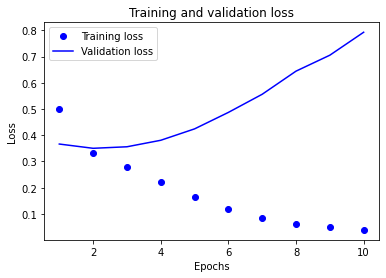

In [83]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

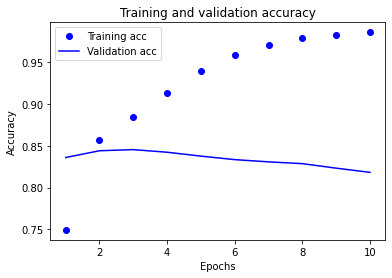

In [84]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 사전 학습 임베딩

In [85]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 (변경가능한 하이퍼파라미터)

# 모델 구성
cnn_model = keras.Sequential()
cnn_model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
cnn_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn_model.add(keras.layers.MaxPooling1D(5))
cnn_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn_model.add(keras.layers.GlobalMaxPooling1D())
cnn_model.add(keras.layers.Dense(8, activation='relu'))
cnn_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
cnn_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 47, 200)           2000000   
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 41, 16)            22416     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 8, 16)             0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 2, 16)             1808      
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 16)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                

In [86]:
# 학습의 진행
cnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = cnn_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
188/188 [==============================] - 6s 31ms/step - loss: 0.6643 - accuracy: 0.5654 - val_loss: 0.4930 - val_accuracy: 0.7569
Epoch 2/5
188/188 [==============================] - 6s 30ms/step - loss: 0.4545 - accuracy: 0.7873 - val_loss: 0.4173 - val_accuracy: 0.8084
Epoch 3/5
188/188 [==============================] - 6s 30ms/step - loss: 0.3732 - accuracy: 0.8363 - val_loss: 0.3915 - val_accuracy: 0.8231
Epoch 4/5
188/188 [==============================] - 6s 30ms/step - loss: 0.3187 - accuracy: 0.8653 - val_loss: 0.3808 - val_accuracy: 0.8285
Epoch 5/5
188/188 [==============================] - 6s 30ms/step - loss: 0.2863 - accuracy: 0.8817 - val_loss: 0.3866 - val_accuracy: 0.8301


In [87]:
# 테스트셋을 통한 모델 평가
results = cnn_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3941 - accuracy: 0.8288
[0.3941490948200226, 0.8287527561187744]


* 정확도가 좋아졌다

In [88]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


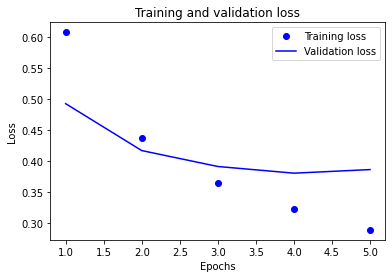

In [89]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

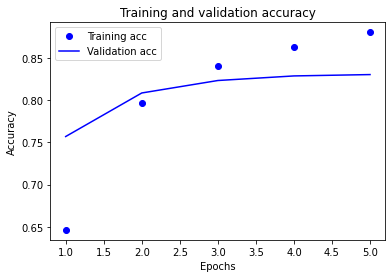

In [90]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

* 그래프를 비교해보면 한국어 Word2Vec 임베딩을 활용한 뒤 validation 그래프모양이 training 그래프모양과 비슷해진 것을 볼 수 있다.

## 모델 3 - GlobalMaxPooling1D

### 자체 학습 임베딩

In [140]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

GMP_model = keras.Sequential()
GMP_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
GMP_model.add(keras.layers.GlobalMaxPooling1D())
GMP_model.add(keras.layers.Dense(8, activation='relu'))
GMP_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

GMP_model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, None, 200)         2000000   
_________________________________________________________________
global_max_pooling1d_14 (Glo (None, 200)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 8)                 1608      
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


In [141]:
# model 학습을 시작해 봅시다.

GMP_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history =GMP_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/10
188/188 [==============================] - 5s 24ms/step - loss: 0.6101 - accuracy: 0.7205 - val_loss: 0.3613 - val_accuracy: 0.8414
Epoch 2/10
188/188 [==============================] - 4s 24ms/step - loss: 0.3294 - accuracy: 0.8630 - val_loss: 0.3388 - val_accuracy: 0.8516
Epoch 3/10
188/188 [==============================] - 4s 24ms/step - loss: 0.2710 - accuracy: 0.8897 - val_loss: 0.3419 - val_accuracy: 0.8529
Epoch 4/10
188/188 [==============================] - 4s 23ms/step - loss: 0.2308 - accuracy: 0.9089 - val_loss: 0.3535 - val_accuracy: 0.8527
Epoch 5/10
188/188 [==============================] - 4s 23ms/step - loss: 0.1897 - accuracy: 0.9295 - val_loss: 0.3725 - val_accuracy: 0.8509
Epoch 6/10
188/188 [==============================] - 4s 23ms/step - loss: 0.1525 - accuracy: 0.9483 - val_loss: 0.4054 - val_accuracy: 0.8480
Epoch 7/10
188/188 [==============================] - 4s 23ms/step - loss: 0.1163 - accuracy: 0.9641 - val_loss: 0.4335 - val_accuracy: 0.8467

In [142]:
# 학습이 끝난 모델을 테스트셋으로 평가
results = GMP_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.5541 - accuracy: 0.8368
[0.554091215133667, 0.8368492722511292]


In [143]:
# model.fit() 과정 중의 train/validation loss, accuracy 등이 매 epoch마다 history 변수에 저장되어 있습니다.
# 이 데이터를 그래프로 그려 보면, 수행했던 딥러닝 학습이 잘 진행되었는지, 오버피팅 혹은 언더피팅하지 않았는지, 성능을 개선할 수 있는 다양한 아이디어를 얻을 수 있는 좋은 자료가 됩니다.
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


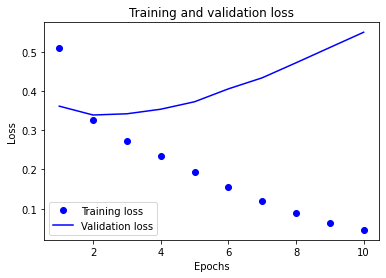

In [144]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

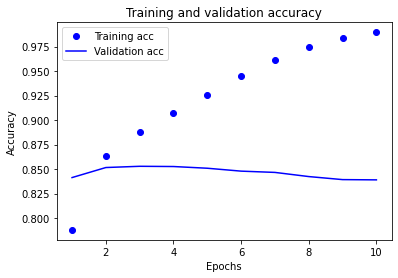

In [145]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 사전 학습 임베딩

In [146]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 (변경가능한 하이퍼파라미터)

# 모델 구성
GMP_model = keras.Sequential()
GMP_model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
GMP_model.add(keras.layers.GlobalMaxPooling1D())
GMP_model.add(keras.layers.Dense(8, activation='relu'))
GMP_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

GMP_model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 47, 200)           2000000   
_________________________________________________________________
global_max_pooling1d_15 (Glo (None, 200)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 8)                 1608      
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


In [147]:
# model 학습을 시작해 봅시다.

GMP_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=12  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history =GMP_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/12
188/188 [==============================] - 5s 24ms/step - loss: 0.7394 - accuracy: 0.5169 - val_loss: 0.6767 - val_accuracy: 0.5691
Epoch 2/12
188/188 [==============================] - 4s 23ms/step - loss: 0.6597 - accuracy: 0.6073 - val_loss: 0.5852 - val_accuracy: 0.6913
Epoch 3/12
188/188 [==============================] - 4s 24ms/step - loss: 0.5642 - accuracy: 0.7113 - val_loss: 0.5256 - val_accuracy: 0.7379
Epoch 4/12
188/188 [==============================] - 4s 23ms/step - loss: 0.5028 - accuracy: 0.7573 - val_loss: 0.4886 - val_accuracy: 0.7646
Epoch 5/12
188/188 [==============================] - 4s 23ms/step - loss: 0.4591 - accuracy: 0.7857 - val_loss: 0.4616 - val_accuracy: 0.7809
Epoch 6/12
188/188 [==============================] - 4s 23ms/step - loss: 0.4284 - accuracy: 0.8026 - val_loss: 0.4445 - val_accuracy: 0.7917
Epoch 7/12
188/188 [==============================] - 4s 23ms/step - loss: 0.4066 - accuracy: 0.8157 - val_loss: 0.4326 - val_accuracy: 0.7992

In [148]:
# 학습이 끝난 모델을 테스트셋으로 평가
results = GMP_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4157 - accuracy: 0.8134
[0.41567814350128174, 0.8133531212806702]


In [149]:
# model.fit() 과정 중의 train/validation loss, accuracy 등이 매 epoch마다 history 변수에 저장되어 있습니다.
# 이 데이터를 그래프로 그려 보면, 수행했던 딥러닝 학습이 잘 진행되었는지, 오버피팅 혹은 언더피팅하지 않았는지, 성능을 개선할 수 있는 다양한 아이디어를 얻을 수 있는 좋은 자료가 됩니다.
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


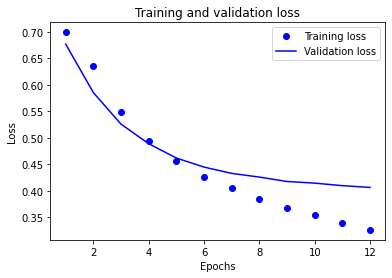

In [150]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

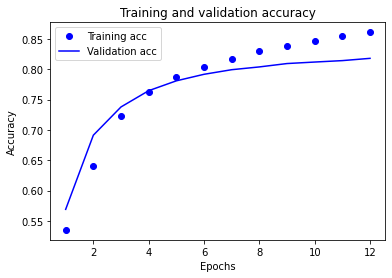

In [151]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

* 자체학습임베딩일때는 validation 그래프가 이상했는데, 사전학습임베딩 활용 시 training과 validation 그래프가 비슷해졌다.

***

# 회고

## 1. 모델별 성능

|모델|한국어 Word2Vec 임베딩 활용 전 정확도|한국어 Word2Vec 임베딩 활용 후 정확도|
|:---:|:--:|:--:|
|LSTM|0.8489|0.8507|
|1-D CNN|0.8159|0.8288|
|GlobalMaxPooling1D|0.8368|0.8134|

* LSTM 일 때, 정확도가 제일 높았다.
* GlobalMaxPooling1D 일때만 한국어 Word2Vec 임베딩 활용 후 정확도가 활용 전보다 낮아졌다.

## 2. gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩 분석

　　　　　　　　word_vectors.similar_by_word("짜증")　　　　　　　　　　　　　　　　　　　　                                                   word2vec.similar_by_word("짜증")
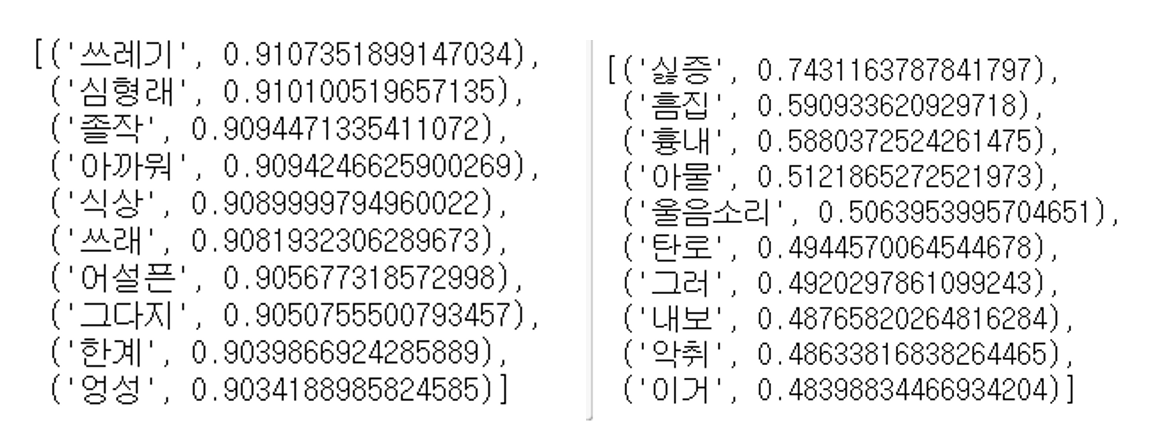

* 자체학습한 임베딩은 확실히 영화리뷰로 학습한 것이여서 그런지 쓰레기, 아까워(돈이나 시간이 아깝다는 뜻인거 같다) 등의 영화에 대한 부정적인 평에 나오는 단어들이 나왔다. 사전 학습 임베딩은 싫증, 악취, 울음소리 등의 영화리뷰랑은 관련 없는 평범한,,? 일반적인..? 단어들이 나왔다. 그런데 사전학습 임베딩을 통한 유사단어찾기 결과가 더 좋다고 할 수는 없는거 같다. 둘다 비슷비슷한 결과를 보여준듯한..
* 그래서 정확도가 크게 늘어나지 않은 것일까? 
* Word2Vec을 정상적으로 잘 활용하면 그렇지 않은 경우보다 5% 이상의 성능향상이 발생한다는데 `정상적으로 잘 활용`하는 방법을 찾아야봐야겠다.

## 3. 느낀점 / 궁금한 점

* 자체학습임베딩일 땐, 그래프를 보면 epoch이 증가할수록 validation loss가 증가하거나 엄청 작게 감소했다. 또는 val_accuracy가 줄어들었다. => training set에 오버피팅된것일까?
* 한국어 Word2Vec 임베딩 활용 후, 그래프를 보면 validation과 training 그래프가 비슷하게 그려졌다. 
 <br>
 
 
* GlobalMaxPooling1D 모델 => 한국어 Word2Vec 임베딩 활용 전엔 그래프모양이 이상했는데 활용 후에 다른 모델들보다 training 과 validaiton 그래프모양이 가장 비슷하게 그려졌다. 하지만 정확도는 떨어졌다. => validation set에 오버피팅 된 걸까? 